<a href="https://colab.research.google.com/github/AdamKimhub/Msproject1/blob/main/Demonstration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install mp-api ase torch_geometric

    from google.colab import drive
    drive.mount('/content/drive')
    original_data = "/content/drive/My Drive/original_dataset"
    final_data = "/content/drive/My Drive/final_dataset"
else:
    original_data = "original_dataset"
    final_data = "final_dataset"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pymatgen.core import Structure
from pymatgen.io.ase import AseAtomsAdaptor
from ase.visualize.plot import plot_atoms

import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

import to_graph
import models

In [ ]:
# Load the model
the_model = models.GNNModel()
model_path = f"{final_data}/BG_model.pth"
the_model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [4]:
def get_prediction(defective_cif, pristine_cif, actual_value=None, vis=False):
    # Pristine structue
    pristine = Structure.from_file(pristine_cif)
    # Defective structure
    defective = Structure.from_file(defective_cif)
    # Cloud structure
    cloud = to_graph.get_defects_structure(defective, pristine)

    if vis:
        fig, num = plt.subplots(1,3, figsize=(15,5))
        # Visualize the pristine structure
        new_pristine = AseAtomsAdaptor.get_atoms(pristine)
        plot_atoms(new_pristine, num[0])
        num[0].set_title("Structure without defects")

        # Visualize the defective structure
        new_defective = AseAtomsAdaptor.get_atoms(defective)
        plot_atoms(new_defective, num[1])
        num[1].set_title("Structure with defects")

        # Visualize the structure without defects
        new_cloud = AseAtomsAdaptor.get_atoms(cloud)
        plot_atoms(new_cloud, num[2])
        num[2].set_title("Defects only structure")

    nodes, edges, edge_features, ids, ratios = to_graph.get_c_graph(cloud)

    the_data = Data(
        x=torch.tensor(nodes, dtype=torch.float),
        edge_index=torch.tensor(edges, dtype=torch.long),
        edge_attr=torch.tensor(edge_features, dtype=torch.float),
        the_ids = torch.tensor(ids, dtype=torch.long).unsqueeze(0),
        the_ratios = torch.tensor(ratios, dtype=torch.float).unsqueeze(0)
    )

    attempt = DataLoader([the_data], batch_size=1, shuffle=False)

    # Make prediction
    the_prediction = models.predict(the_model, attempt)[0]

    if actual_value is not None:
        output = f"The predicted band gap: {the_prediction}\t The actual band gap: {actual_value}"
        return output

    else:
        output = f"The predicted band gap: {the_prediction}"
        return output

In [ ]:
# Lets predict from all the materials
materials = ["high_BN", "high_P", "high_InSe", "high_GaSe", "high_MoS2", "high_WSe2", "low_MoS2", "low_WSe2"]
materials_df = [pd.read_csv(f"{final_data}/combined/{material}.csv") for material in materials]

example_df = [df.sample(n=3) for df in materials_df]

all_examples = pd.concat(example_df, ignore_index=True)
all_examples

,Unnamed: 0,_id,dataset_material,band_gap_value,strata
11938,11938,619cdd7645851b2ed2431a7c,low_WSe2,0.1754,33
8643,8643,6143b0079cbada84a8676d8b,low_MoS2,1.8096,32
9477,9477,619cdd5745851b2ed24310df,low_WSe2,1.2671,33


/usr/local/lib/python3.11/dist-packages/pymatgen/core/structure.py:3107: UserWarning: Issues encountered while parsing CIF: 48 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]


The predicted band gap: 0.19915653765201569	 The actual band gap: 0.1753999999999997
The predicted band gap: 1.747499704360962	 The actual band gap: 1.8096000000000032
The predicted band gap: 1.239858865737915	 The actual band gap: 1.2670999999999992


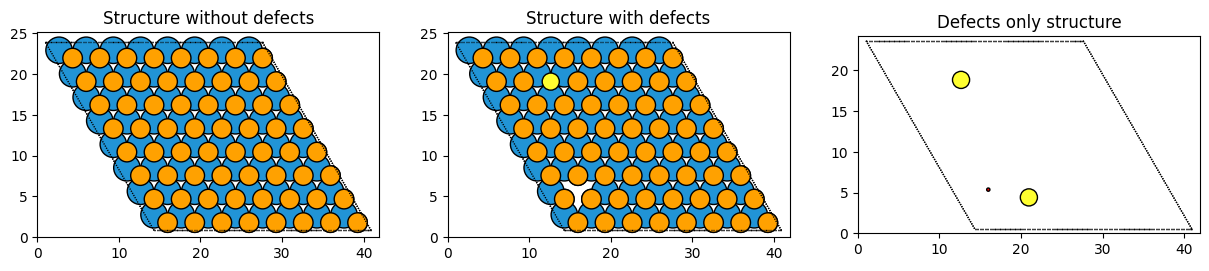

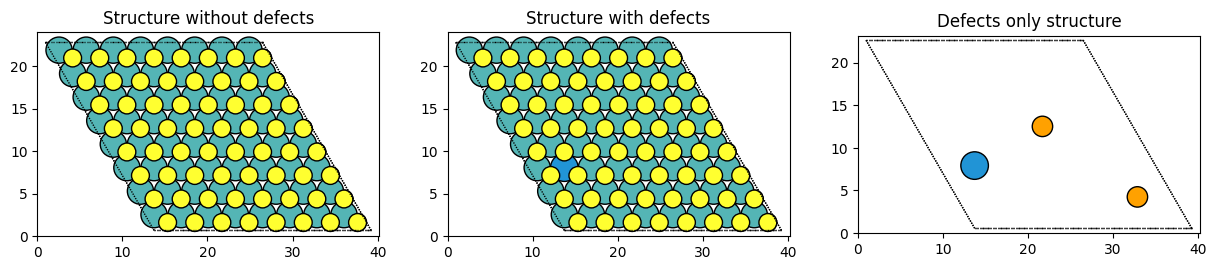

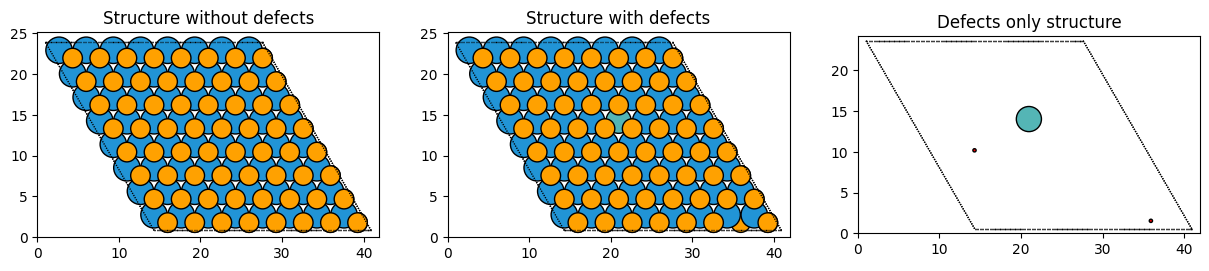

In [ ]:
for index, row in all_examples.iterrows():
# for index, row in example2.iterrows():
    defective_id = row["_id"]
    pristine_id = row["dataset_material"]
    actual = row["band_gap_value"]

    defective_cif = f"{original_data}/{pristine_id}/cifs/{defective_id}.cif"
    pristine_cif = f"{final_data}/ref_cifs/{pristine_id}.cif"

    print(get_prediction(defective_cif, pristine_cif, actual, vis=True))